<a href="https://colab.research.google.com/github/jingtang10/odhs-genai/blob/main/%5BODHS_D2_T1_05A_CL3%5D_Gemma_WHO_ANC_Guidelines_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [ ]:
import os
from google.colab import userdata

In [ ]:
!pip install -qU datasets
!pip install -qU langchain
!pip install -qU transformers
!pip install -qU langchain-community
!pip install -qU sentence-transformers
!pip install -qU pypdf
!pip install -qU faiss-gpu

In [ ]:
from tqdm.notebook import tqdm

## Setup Vector Store with epfl/guidelines

In [ ]:
from datasets import load_dataset

guidelines_ds = load_dataset("epfl-llm/guidelines")

In [ ]:
who_guidelines = guidelines_ds.filter(lambda ex: ex['source'] == 'who')

In [ ]:
who_guidelines['train']['clean_text'][0]

'consultants on the reviews of the harm of substance use in pregnancy and breastfeeding); Margaret Harris (consultant in WHO guideline methodology, who prepared the guideline document and advised at the GDG meeting in Geneva); Keryn Murphy (who wrote the meeting report of the meeting in Washington DC); Nandi Siegfried (WHO consultant on systematic review, GRADE and WHO guideline methodology, and advisor at the GDG meeting in Washington DC, who conducted the reviews and prepared the GRADE tables on the effectiveness of interventions for substance use disorders).# Objectives and scope of these guidelines\nUse of alcohol, illicit drugs and other psychoactive substances during pregnancy is common and can lead to multiple health and social problems for both mother and child.\nUse of alcohol during pregnancy can lead to fetal alcohol syndrome and other harms such as spontaneous abortion, stillbirth, low birthweight, prematurity and birth defects. Use of alcohol and other drugs can also sever

Guidance from https://huggingface.co/learn/cookbook/en/advanced_rag

In [ ]:
from langchain.docstore.document import Document as LangchainDocument

RAW_KNOWLEDGE_BASE = [
    LangchainDocument(page_content=doc["clean_text"], metadata={"source": doc["source"]}) for doc in tqdm(who_guidelines['train'])
]

  0%|          | 0/223 [00:00<?, ?it/s]

## Setup Vector Store with WHO ANC Guidelines

In [ ]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader("9789241549912-eng.pdf")
who_guidelines_pages = []
for index, page in enumerate(loader.load()):
  if index < 2 or index > 50:
    continue
  who_guidelines_pages.append(page)

print(f"{who_guidelines_pages[0].metadata}\n")
print(who_guidelines_pages[0].page_content)

{'source': '9789241549912-eng.pdf', 'page': 2}

WHO recommendations on antenatal care 
for a positive pregnancy experience


In [ ]:
from langchain.docstore.document import Document as LangchainDocument

RAW_KNOWLEDGE_BASE = [
    LangchainDocument(page_content=page.page_content, metadata={"source": "WHO"}) for page in tqdm(who_guidelines_pages)
]

  0%|          | 0/49 [00:00<?, ?it/s]

In [ ]:
# from https://huggingface.co/learn/cookbook/en/advanced_rag
from langchain.text_splitter import RecursiveCharacterTextSplitter
from transformers import AutoTokenizer
from typing import Optional, List, Tuple


MARKDOWN_SEPARATORS = [
    "\n#{1,6} ",
    "```\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n___+\n",
    "\n\n",
    "\n",
    " ",
    "",
]

EMBEDDING_MODEL_NAME = "Snowflake/snowflake-arctic-embed-m"


def split_documents(
    chunk_size: int,
    knowledge_base: List[LangchainDocument],
    tokenizer_name: Optional[str] = EMBEDDING_MODEL_NAME,
) -> List[LangchainDocument]:
    """
    Split documents into chunks of maximum size `chunk_size` tokens and return a list of documents.
    """
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(tokenizer_name),
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
        separators=MARKDOWN_SEPARATORS,
    )

    docs_processed = []
    for doc in knowledge_base:
        docs_processed += text_splitter.split_documents([doc])

    # Remove duplicates
    unique_texts = {}
    docs_processed_unique = []
    for doc in docs_processed:
        if doc.page_content not in unique_texts:
            doc.metadata["doc_idx"] = len(docs_processed_unique) # since this will be added, but isn't yet
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)

    return docs_processed_unique


docs_processed = split_documents(
    512,  # We choose a chunk size adapted to our model
    RAW_KNOWLEDGE_BASE,
    tokenizer_name=EMBEDDING_MODEL_NAME,
)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

In [ ]:
docs_processed[20]

Document(metadata={'source': 'WHO', 'start_index': 0, 'doc_idx': 20}, page_content='WHO recommendations on antenatal care for a positive pregnancy experience\nxii\nZinc supplements A.5: Zinc supplementation for pregnant women is only recommended in \nthe context of rigorous research.\nContext-specific \nrecommendation \n(research)\nMultiple \nmicronutrient \nsupplements\nA.6: Multiple micronutrient supplementation is not recommended for \npregnant women to improve maternal and perinatal outcomes.\nNot recommended\nVitamin B6 \n(pyridoxine) \nsupplements\nA.7: Vitamin B6 (pyridoxine) supplementation is not recommended for \npregnant women to improve maternal and perinatal outcomes.\nNot recommended\nVitamin E and C \nsupplements\nA.8: Vitamin E and C supplementation is not recommended for pregnant \nwomen to improve maternal and perinatal outcomes.\nNot recommended\nVitamin D \nsupplements\nA.9: Vitamin D supplementation is not recommended for pregnant \nwomen to improve maternal and pe

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]

  0%|          | 0/125 [00:00<?, ?it/s]

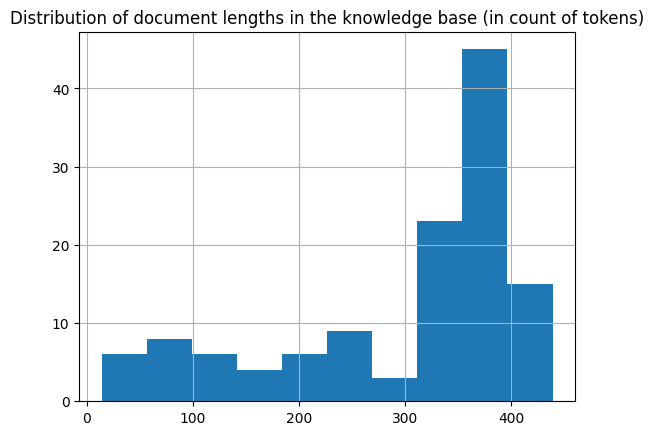

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

In [ ]:
!nvidia-smi

Sat Nov 30 10:34:54 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy

embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},  # Set `True` for cosine similarity
)

KNOWLEDGE_VECTOR_DATABASE = FAISS.from_documents(
    docs_processed, embedding_model, distance_strategy=DistanceStrategy.COSINE
)

<ipython-input-23-86d3e6721df3>:5: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/84.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/107 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/738 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

In [ ]:
retrieved_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query="What is the recommended daily dose of elemental iron for pregnant women to prevent anemia?", k=10)

In [ ]:
gemma = AutoTokenizer.from_pretrained("google/gemma-2-2b-it", token=userdata.get('HF_TOKEN'))

tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

### Load Q/A Data


In [ ]:
import pandas as pd

mcq_df = pd.read_csv('mcq_questions.csv')
mcq_df["Gemini Answer"] = mcq_df["Choice"].tolist()

In [ ]:
sqa_df = pd.read_csv('sqa_questions.csv')
sqa_df["Gemini Answer"] = sqa_df["Answer"].tolist()

## Prompt Builder Helpers

In [ ]:
# @title Materialize similartiy search to play more easily with prompt templates
def getModelTurn(model_resp: str)->str:
  model_turn_idx = model_resp.find("<start_of_turn>model")
  return model_resp[model_turn_idx:]

def build_prompt_nochat(example)->str:
  """
  Builds a prompt without using the "chat" instruction template.
  TODO: use this in build_prompt below for composability.
  """
  return f"""The following are multiple choice questions
(with answers) about medical knowledge based on World Health Organization (WHO) guidelines. Give me the answer.
  **Question:** {example['Question']}
  (A) {example['A']}
  (B) {example['B']}
  (C) {example['C']}
  (D) {example['D']}

  Answer this question in the following format:
**Answer:** (Z)"""

from io import StringIO

def build_prompt(example, retrieved_docs)->str:
  rag_str = StringIO()
  total_tokens = 0
  token_limit = 4000
  for doc in retrieved_docs:
    # Get 3 subsequent docs
    new_doc = doc.page_content + docs_processed[doc.metadata['doc_idx']+1].page_content + docs_processed[doc.metadata['doc_idx']+2].page_content
    new_tokens = len(gemma.tokenize(new_doc))
    if total_tokens + new_tokens > token_limit:
      break
    rag_str.write("\n\n"+new_doc+"\n\n")
    total_tokens += new_tokens

  return f"""<bos><start_of_turn>user
  You are an expert on World Health Organization guidelines. I will ask you a
  multiple choice question, and will include some context from the WHO guidelines
  that you may choose to use to answer the question if it is useful. It is okay
  if you do not use the provided context to answer the question.

  ====================================================================
  Begin retrieved context
  ====================================================================

  {rag_str.getvalue()}

  ====================================================================
  End retrieved context
  ====================================================================

The following are multiple choice questions
(with answers) about medical knowledge based on World Health Organization (WHO) guidelines. Give me the answer.
If all the answer choices are correct, select (D) All of the above. Even if the context does not provide relevant information, please still answer the question.
  **Question:** {example['Question']}
  (A) {example['A']}
  (B) {example['B']}
  (C) {example['C']}
  (D) {example['D']}

Even if the context does not provide relevant information, please still answer the question. Always answer the question.

  Answer this question in the following format:
**Answer:** (Z)
<end_of_turn>
<start_of_turn>model"""

def build_inference_example(example, retrieved_docs):
  return {"prompt": build_prompt(example, retrieved_docs), "answer": f"({example['Gemini Answer']})"}

def build_sqa_inference_example(example, retrieved_docs):
  return {"prompt": build_sqa_prompt(example, retrieved_docs), "answer": f"({example['Gemini Answer']})"}

def build_inference_example_nochat(example):
  return {"prompt": build_prompt_nochat(example), "answer": f"({example['Gemini Answer']})"}

In [ ]:
def build_sqa_prompt(example, retrieved_docs)->str:
  # retrieved_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query=example['Question'], k=5)
  rag_str = StringIO()
  total_tokens = 0
  token_limit = 4000
  for doc in retrieved_docs:
    # Get 3 subsequent docs
    new_doc = doc.page_content + docs_processed[doc.metadata['doc_idx']+1].page_content + docs_processed[doc.metadata['doc_idx']+2].page_content
    new_tokens = len(gemma.tokenize(new_doc))
    if total_tokens + new_tokens > token_limit:
      break
    rag_str.write("\n\n"+new_doc+"\n\n")
    total_tokens += new_tokens

  return f"""You are an expert on World Health Organization guidelines. I will ask you a
  question, and will include some context from the WHO guidelines
  that you may choose to use to answer the question if it is useful. It is okay
  if you do not use the provided context to answer the question.

  ====================================================================
  Begin retrieved context
  ====================================================================

  {rag_str.getvalue()}

  ====================================================================
  End retrieved context
  ====================================================================

Instructions for short answers:
The number words should be strictly between 10 to 20 words.
Do not provide answers with less than three words.
Even if the above context does not provide relevant information, please still answer the question.

Follow this format as an example:
**Question:** {example['Question']}
**Answer:**"""

## Select the model

In [ ]:
gemma_model_name = "google/gemma-2-2b-it" #@param ["google/gemma-2-2b-it","google/gemma-2-9b-it"]

Every prompt you send to the model includes parameters that control how the model generates responses.

- `temperature`: Controls the randomness of the model's output. A higher value (closer to 1) makes the output more diverse, while a lower value (closer to 0) makes it more focused and deterministic.
- `top_p`: Implements nucleus sampling, which selects the smallest set of tokens whose cumulative probability is greater than or equal to this value (e.g., 0.95), promoting diversity by considering multiple tokens.
- `max_new_tokens`: The maximum number of new tokens to generate in the model's output.
- `repetition_penalty`: Penalizes the model for repeating tokens that have already been generated. A value above 1 discourages repetition.
- `no_repeat_ngram_size`: Prevents the model from repeating phrases of this size (e.g., 2-gram means no repeated pairs of words).


In [ ]:
temperature = 0.7 #@param {type:"slider", min:0, max:1, step:0.1}
top_p = 0.95 #@param {type:"slider", min:0, max:1, step:0.05}
max_new_tokens = 256 #@param {type:"integer"}
repetition_penalty = 1.2 #@param {type:"slider", min:1, max:2, step:0.1}
no_repeat_ngram_size = 2 #@param {type:"integer"}


### Utility Functions

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

In [ ]:
def model(model_name:str):
  """
  Loads a tokenizer and model for a specified pre-trained causal language model.

  Args:
      model_name (str): The name or path of the pre-trained model to load.

  Returns:
      tuple: A tuple containing:
          - tokenizer: The tokenizer corresponding to the specified model,
            loaded using AutoTokenizer.
          - model: The pre-trained causal language model loaded using AutoModelForCausalLM.

  The model is loaded with automatic device mapping (i.e., device_map="auto")
  and uses bfloat16 precision (torch_dtype=torch.bfloat16).
  """
  tokenizer = AutoTokenizer.from_pretrained(model_name)
  model = AutoModelForCausalLM.from_pretrained(
          model_name,
          device_map="auto",
          torch_dtype=torch.bfloat16,)
  return tokenizer, model

In [ ]:
tokenizer, model = model(gemma_model_name)

config.json:   0%|          | 0.00/838 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

In [ ]:
# Selects the device based on the availability

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def generate(
    model,
    input_ids
)-> torch.Tensor:
  """
  Generates text using a pre-trained language model with customizable parameters.

  Args:
      model: The pre-trained language model used for text generation.
      input_ids: The input tokens for the model, typically the tokenized input text.

  Returns:
      outputs: The generated text tokens from the model based on the given parameters.
  """
  outputs = model.generate(**input_ids,
                           max_new_tokens = max_new_tokens,
                           temperature = temperature,
                           top_p = top_p,
                           repetition_penalty=repetition_penalty,
                           no_repeat_ngram_size=no_repeat_ngram_size)
  return outputs




In [ ]:
def get_option_or_answer(
    output,
    item_type: str
) -> str:
    """
    Extracts and returns the option or answer from the provided text output based on the specified item type.

    Args:
        output (str): The output text containing the answer, assumed to have the format "Answer: <content>".
        item_type (str): The type of item, either "mcq" for multiple-choice questions or "sqa" for short-answer questions.

    Returns:
        str: The extracted option (first character after "Answer:") if `item_type` is "mcq".
             For "sqa", returns the full answer after "Answer:", with extra whitespace and asterisks removed.
             If no answer is found for "mcq", returns "None".
    """
    if item_type == "mcq":
        option = output.split("model** Answer:")[1].strip()
        option = option.replace("*", "")
        option = option.replace("(", "").strip()

        if option == "" or option[0] not in ["A", "B", "C", "D"]:
            return None

        return option[0]
    elif item_type == "sqa":
        answer = output.split("Answer:")[1].strip()
        answer = answer.replace("\n", " ")
        answer = answer.replace("*", "")
        answer = " ".join(answer.split())
        return answer


In [ ]:
mcq_prompts = []
retrieved_docs = []
for _, row in tqdm(mcq_df.iterrows(), total=len(mcq_df)):
  r_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query=row['Question'], k=8)
  mcq_prompts.append(build_inference_example(row, r_docs))
  retrieved_docs.append(r_docs)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
raw_text_outputs = []
mcq_gemma_results = []
for index in tqdm(range(len(mcq_prompts)), total=len(mcq_prompts)):
  input_ids = tokenizer(mcq_prompts[index]["prompt"], return_tensors="pt").to(device)
  outputs = generate(model, input_ids)
  output = tokenizer.decode(outputs[0], skip_special_tokens=True)
  raw_text_outputs.append(output)
  option = get_option_or_answer(output, "mcq")
  mcq_gemma_results.append(option)

mcq_df["Gemma Answer"] = mcq_gemma_results

  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:595: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


In [ ]:
mcq_df.to_csv("mcq_answers.csv")

In [ ]:
sqa_prompts = []
retrieved_docs = []
for index, row in tqdm(sqa_df.iterrows(), total=len(sqa_df)):
  r_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query=row.Question, k=8)
  sqa_prompts.append(build_sqa_inference_example(row, r_docs))
  retrieved_docs.append(r_docs)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
raw_text_outputs = []
sqa_gemma_results = []
for index in tqdm(range(len(sqa_prompts)), total=len(sqa_prompts)):
  input_ids = tokenizer(sqa_prompts[index]["prompt"], return_tensors="pt").to(device)
  outputs = generate(model, input_ids)
  output = tokenizer.decode(outputs[0], skip_special_tokens=True)
  raw_text_outputs.append(output)
  answer = get_option_or_answer(output, "sqa")
  sqa_gemma_results.append(answer)

sqa_df["Gemma Answer"] = sqa_gemma_results

  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:595: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


In [ ]:
sqa_df.to_csv("sqa_answers.csv")